<a href="https://colab.research.google.com/github/dwtkse33/ml_GoogleColab/blob/master/%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증 

*   교차 검증의 의미 
* 실습 
* 참고: https://yamalab.tistory.com/44 ;
https://chloevan.github.io/python/python_edu/04_machinelearning/chapter_4_2_cross_val/#%EA%B0%9C%EC%9A%94



###방법 1. 홀드아웃 
* 데이터: 훈련데이터와 테스트데이터로 나누어 검증
 

###방법2. K폴드 교차검증 

*   raw데이터를 다양한 카테로리로 분류
* 데이터의 수가 적을 때 주로 사용 (Default 연산량 * K개 만큼) 
* + 훈련데이터 : 훈련데이터 + 검증데이터 --> 테스트데이터 



cross_val_score

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import stats
from sklearn.datasets import load_boston
# 사이파이(SciPy)는 수치해석기능을 제공하는 파이썬 패키지다. 여러 서브패키지로 구성되어 있는데 
#그중 stats 서브패키지는 확률분포 분석을 위한 다양한 기능을 제공한다. 다음 코드로 임포트한다.

### 데이터 탐색 
* 시각화, 통계 검정 
* 변수 정의 

Data Set Characteristics:

Number of Instances
506

Number of Attributes
13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

Attribute Information (in order)
CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS proportion of non-retail business acres per town

CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT % lower status of the population

MEDV Median value of owner-occupied homes in $1000’s

In [13]:
%matplotlib inline
boston = load_boston()

#pandas dataframe, 독립변수
bostonDF = pd.DataFrame(data=boston.data, columns=boston.feature_names)
#주의: pdDataFrame(~~columns=boston , feature_names)이 아님 

#종속변수 
bostonDF["PRICE"] = boston.target
print("Size of dataset : ", bostonDF.shape)

Size of dataset :  (506, 14)


(아래-참고용) 보스턴 데이터의 경우 0과 1로 표현된 CHAS 데이터를 제외하고는 가격을 포함한 대부분의 데이터가 양수인 실수이다. seaborn의 pairplot 명령으로 각 데이터의 분포와 데이터들간의 상관관계를 파악한다. 다음 그림에는 일부 데이터만을 보였으나 이 그림만으로도 가격(MEDV)과 RM 데이터가 강한 양의 상관관계를 가지는 것을 볼 수 있다. 또한 스캐터플롯상으로 볼 때는 AGE나 RAD 데이터는 가격과 음의 상관관계를 가지는 것처럼 보인다. 실제로 이러한 관계가 있는지 이후의 분석과정에서 더 자세히 알아본다.

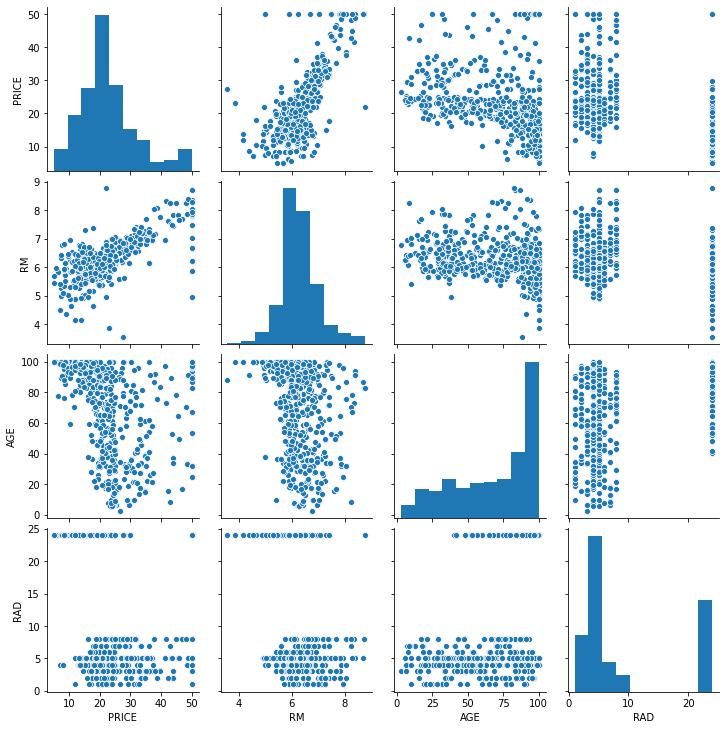

In [25]:
#이건 검증은 아니고 상관관계 파악하기 위한 참고용(보통 사전 분석할때 사용 코드)
import seaborn as sns
cols = ["PRICE", "RM", "AGE", "RAD"]
sns.pairplot(bostonDF[cols])
plt.show()

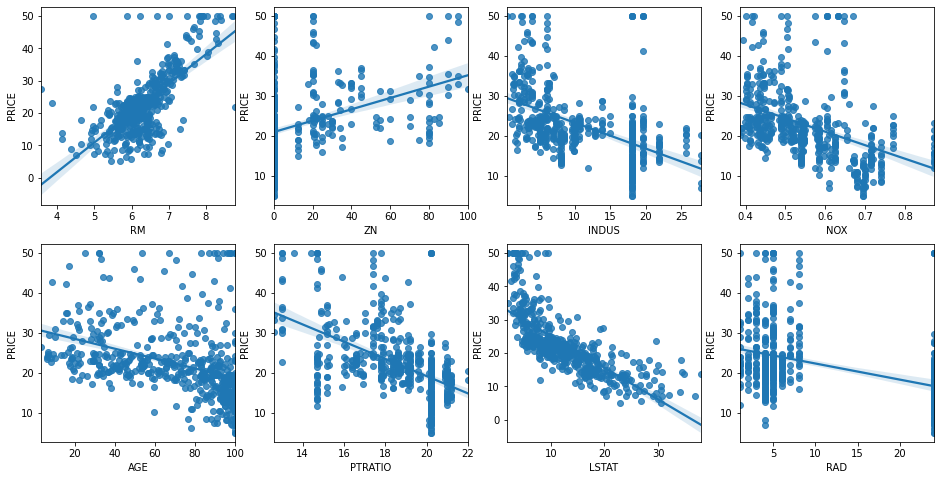

In [27]:
#주요 변수별 데이터를 해석할 수 있어야 한다.
# RM: RM이 증가할수록 PRICE도 증가하는 경향이 있다.
# 각각의 변수와 Price와의 관계에 대한 직관적인 이해가 필요하다.
# 질문: 선형성이 가장 큰 것은 무엇인가?
# 이제 회귀 모형을 만들어본다.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE', data=bostonDF , ax=axs[row][col])

# 머신러닝 모형 만들기

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 훈련데이터, 테스트 분리 
y_target = bostonDF["PRICE"]
x_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size= 0.3, random_state= 1)

# 모형을 만들기-선형회귀 
ir_model = LinearRegression()
ir_model.fit(x_train, y_train)

#예측
y_preds = ir_model.predict(x_test)

mean_squared_error(MSE) : 실제값과 예측값의 차이를 제곱 후 평균 
RMSE : 실제 오류 평균보다 더 커지는 특성이 있어서 루트 씌움 

In [26]:
mse = mean_squared_error(y_test, y_preds)
print(mse)
# mean squared error :  the sum differences between our target and predicted variables

19.831323672062922


In [17]:
rmse = np.sqrt(mse)
print(mse)

19.831323672062922


### K 폴드 적용
* cross_val_score() 함수 활용해서 RMSE 
  + 5 폴드값, 값이 

In [19]:
from sklearn.model_selection import cross_val_score 
neg_mse_scores= cross_val_score(ir_model, x_data, y_target, scoring="neg_mean_squared_error", cv= 5)
print(neg_mse_scores)
# mse를 음수값으로 출력해달라는 명령 

[-12.46030057 -26.04862111 -33.07413798 -80.76237112 -33.31360656]


In [20]:
rmse_scores = np.sqrt(-1 * neg_mse_scores)
print(rmse_scores)

[3.52991509 5.10378498 5.75101191 8.9867887  5.77179405]


In [21]:
np.mean(rmse_scores)

5.828658946215802